In [6]:
import numpy as np
from braindecode.datasets import MOABBDataset

subject_id = [1,2,3,4]
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[1,2,3,4,5,6,7,8,9])



from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor,
)

low_cut_hz = 4.0  # low cut frequency for filtering
high_cut_hz = 38.0  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

transforms = [
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(
        lambda data, factor: np.multiply(data, factor),  # Convert from V to uV
        factor=1e6,
    ),
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(
        exponential_moving_standardize,  # Exponential moving standardization
        factor_new=factor_new,
        init_block_size=init_block_size,
    ),
]

# Transform the data
preprocess(dataset, transforms, n_jobs=-1)


c:\Users\ahmm9\AppData\Local\Programs\Python\Python312\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [7]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info["sfreq"]
assert all([ds.raw.info["sfreq"] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [ ]:
import torch
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200222
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = windows_dataset[0][0].shape[0]
input_window_samples = windows_dataset[0][0].shape[1]

print("n_classes: ", n_classes)
print("n_channels:", n_channels)
print("input_window_samples size:", input_window_samples)

In [ ]:
# The ShallowFBCSPNet is a `nn.Sequential` model

model = ShallowFBCSPNet(
    n_channels,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length="auto",
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model.cuda()



In [9]:
splitted = windows_dataset.split("session")
train_set = splitted['0train']  # Session train
test_set = splitted['1test']  # Session evaluation

from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 100


In [10]:

from tqdm import tqdm
# Define a method for training one epoch


def train_one_epoch(
        dataloader: DataLoader, model: Module, loss_fn, optimizer,
        scheduler: LRScheduler, epoch: int, device, print_batch_stats=True
):
    model.train()  # Set the model to training mode
    train_loss, correct = 0, 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader),
                        disable=not print_batch_stats)

    for batch_idx, (X, y, _) in progress_bar:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()  # update the model weights
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()

        if print_batch_stats:
            progress_bar.set_description(
                f"Epoch {epoch}/{n_epochs}, "
                f"Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}"
            )

    # Update the learning rate
    scheduler.step()

    correct /= len(dataloader.dataset)
    return train_loss / len(dataloader), correct


In [11]:

@torch.no_grad()
def test_model(
    dataloader: DataLoader, model: Module, loss_fn, print_batch_stats=True
):
    size = len(dataloader.dataset)
    n_batches = len(dataloader)
    model.eval()  # Switch to evaluation mode
    test_loss, correct = 0, 0

    if print_batch_stats:
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    else:
        progress_bar = enumerate(dataloader)

    for batch_idx, (X, y, _) in progress_bar:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        batch_loss = loss_fn(pred, y).item()

        test_loss += batch_loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if print_batch_stats:
            progress_bar.set_description(
                f"Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {batch_loss:.6f}"
            )

    test_loss /= n_batches
    correct /= size

    print(
        f"Test Accuracy: {100 * correct:.1f}%, Test Loss: {test_loss:.6f}\n"
    )
    return test_loss, correct

In [ ]:
# Define the optimization
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=n_epochs - 1)
# Define the loss function
# We used the NNLoss function, which expects log probabilities as input
# (which is the case for our model output)
loss_fn = torch.nn.NLLLoss()

# train_set and test_set are instances of torch Datasets, and can seamlessly be
# wrapped in data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}: ", end="")

    train_loss, train_accuracy = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler, epoch, device,
    )

    test_loss, test_accuracy = test_model(test_loader, model, loss_fn)

    print(
        f"Train Accuracy: {100 * train_accuracy:.2f}%, "
        f"Average Train Loss: {train_loss:.6f}, "
        f"Test Accuracy: {100 * test_accuracy:.1f}%, "
        f"Average Test Loss: {test_loss:.6f}\n"
    )

In [13]:
# Assuming 'model' is your trained Braindecode model
torch.save(model, "braindecode_model.pth")
torch.save(model.state_dict(), "braindecode_model_state.pth")


In [3]:
import numpy as np
from braindecode.datasets import MOABBDataset

In [97]:
def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram

import numpy as np

def HSIC(K, L):
    """
    Computes the Hilbert-Schmidt Independence Criterion (HSIC) between two kernel matrices K and L.
    
    Args:
    - K (np.ndarray): Kernel matrix for the first dataset (n x n).
    - L (np.ndarray): Kernel matrix for the second dataset (n x n).
    
    Returns:
    - hsic_value (float): The computed HSIC value.
    """
    # Get the number of samples (n)
    n = K.shape[0]
    
    # Centering matrix H = I - (1/n) * 1_1^T
    H = np.eye(n) - np.ones((n, n)) / n
    
    # Center the kernel matrices
    K_centered = H @ K @ H
    L_centered = H @ L @ H
    
    # Compute HSIC value
    hsic_value = np.trace(K_centered @ L_centered) / ((n - 1) ** 2)
    
    return hsic_value


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


import numpy as np

def feature_space_linear_cka(features_x, features_y, debiased=False):
    """Compute CKA with a linear kernel, in feature space.

    Args:
        features_x: A (num_examples x num_features) matrix.
        features_y: A (num_examples x num_features) matrix.
        debiased: Use an unbiased estimator (optional).

    Returns:
        CKA similarity score.
    """
    gram_x = gram_linear(features_x)
    gram_y = gram_linear(features_y)

    centered_gram_x = center_gram(gram_x)
    centered_gram_y = center_gram(gram_y)

    print("CG_X: ", centered_gram_x)
    print("CG_Y: ", centered_gram_y)

    HSIC_KL = HSIC(centered_gram_x,centered_gram_y)

    print("HSICKL: ", HSIC_KL)

    HSIC_KK = HSIC(centered_gram_x,centered_gram_x)
    print("HSICKL: ", HSIC_KK)
    HSIC_LL = HSIC(centered_gram_y,centered_gram_y)
    print("HSICKL: ", HSIC_LL)

    # Compute dot product similarity
    # similarity = np.sum(centered_gram_x * centered_gram_y)
    
    # # Step 4: Normalize
    # norm_x = np.sqrt(np.sum(centered_gram_x ** 2))
    # norm_y = np.sqrt(np.sum(centered_gram_y ** 2))


    if debiased:
        n = features_x.shape[0]
        sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
        sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
        squared_norm_x = np.sum(sum_squared_rows_x)
        squared_norm_y = np.sum(sum_squared_rows_y)

        similarity = _debiased_dot_product_similarity_helper(
            similarity, sum_squared_rows_x, sum_squared_rows_y,
            squared_norm_x, squared_norm_y, n)
        norm_x = _debiased_dot_product_similarity_helper(
            norm_x, sum_squared_rows_x, sum_squared_rows_x,
            squared_norm_x, squared_norm_x, n)
        norm_y = _debiased_dot_product_similarity_helper(
            norm_y, sum_squared_rows_y, sum_squared_rows_y,
            squared_norm_y, squared_norm_y, n)
    print(HSIC_KL / np.sqrt(HSIC_KK * HSIC_LL))
    return HSIC_KL / np.sqrt(HSIC_KK * HSIC_LL)  # Avoid division instability


In [82]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from braindecode.models import ShallowFBCSPNet

# Define model parameters
in_chans = 22
n_classes = 4
n_channels = 22
input_window_samples = windows_dataset[0][0].shape[1]

# Load two models for comparison
model= torch.load("braindecode_model.pth", weights_only=False)
model2 = ShallowFBCSPNet(in_chans, n_classes, input_window_samples, final_conv_length="auto")
activations_model1 = {}
activations_model2 = {}

def hook_fn(name, activations_dict):
    def hook(module, input, output):
        activations_dict[name] = output.detach()
    return hook

hooks_model1 = {}
hooks_model2 = {}

# Hook into layers of model1
for name, layer in model.named_modules():
    # Explicitly hook the relevant layers and submodules
    if name in ["conv_time_spat", "conv_time_spat.conv_time", "conv_time_spat.conv_spat"] or "." not in name:
        hooks_model1[name] = layer.register_forward_hook(hook_fn(name, activations_model1))

# Hook into layers of model2
for name, layer in model2.named_modules():
    # Explicitly hook the relevant layers and submodules
    if name in ["conv_time_spat", "conv_time_spat.conv_time", "conv_time_spat.conv_spat"] or "." not in name:
        hooks_model2[name] = layer.register_forward_hook(hook_fn(name, activations_model2))


c:\Users\ahmm9\AppData\Local\Programs\Python\Python312\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [83]:
# Example input data
input_data = torch.randn(64, n_channels, input_window_samples)  # Adjust shape as needed

model.eval()
model2.eval()

# Collect activations for model1
with torch.no_grad():
    _ = model(input_data)  # Run the forward pass
    activations_model1_copy = activations_model1.copy()  # Store activations for model1
    activations_model1.clear()  # Clear activations for the next model

# Collect activations for model2
with torch.no_grad():
    _ = model2(input_data)  # Run the forward pass
    activations_model2_copy = activations_model2.copy()  # Store activations for model2
    activations_model2.clear()


In [84]:
print("Captured Activations for Model 1:")
for layer_name, activation in activations_model1_copy.items():
    if(layer_name == "conv_time_spat"):
        print(f"{layer_name}: {activation.shape}")
        print(activation)




Captured Activations for Model 1:
conv_time_spat: torch.Size([64, 40, 1101, 1])
tensor([[[[-0.0404],
          [ 0.2387],
          [ 0.7534],
          ...,
          [ 0.4259],
          [-0.1564],
          [ 0.2759]],

         [[-0.2812],
          [ 0.0557],
          [ 0.3007],
          ...,
          [-0.5563],
          [-0.0246],
          [-0.2012]],

         [[-0.5449],
          [-0.6249],
          [ 0.2088],
          ...,
          [-0.3040],
          [-0.0158],
          [ 0.3009]],

         ...,

         [[-0.2258],
          [-0.0391],
          [ 0.6926],
          ...,
          [ 0.9683],
          [ 0.2142],
          [ 0.4640]],

         [[-0.1130],
          [ 0.5018],
          [ 0.5846],
          ...,
          [-0.2925],
          [-0.1553],
          [-0.4266]],

         [[ 0.4384],
          [-0.2145],
          [-0.6868],
          ...,
          [ 0.5280],
          [-0.2006],
          [ 0.0466]]],


        [[[-0.0616],
          [ 0.1631],
   

In [85]:
print("\nCaptured Activations for Model 2:")
for layer_name, activation in activations_model2_copy.items():
    if(layer_name == "conv_time_spat"):
        print(f"{layer_name}: {activation.shape}")
        print(activation)


Captured Activations for Model 2:
conv_time_spat: torch.Size([64, 40, 1101, 1])
tensor([[[[ 1.3260e-01],
          [-5.7130e-01],
          [ 1.8615e-01],
          ...,
          [-9.7206e-02],
          [-1.7152e-01],
          [ 1.5837e-01]],

         [[-2.7096e-01],
          [-3.0037e-03],
          [-5.5289e-02],
          ...,
          [-1.1376e-02],
          [ 7.1572e-02],
          [-6.0502e-02]],

         [[-1.1381e-01],
          [ 1.6321e-03],
          [-8.6867e-02],
          ...,
          [-6.7003e-03],
          [-4.4563e-04],
          [ 2.2960e-01]],

         ...,

         [[-8.9373e-02],
          [ 5.2318e-02],
          [-6.2561e-02],
          ...,
          [ 5.7589e-01],
          [-4.1469e-01],
          [ 1.4838e-01]],

         [[-4.4264e-01],
          [ 3.8737e-02],
          [-8.5553e-02],
          ...,
          [ 1.6484e-02],
          [-2.7756e-01],
          [ 1.3530e-01]],

         [[-9.7454e-02],
          [ 2.2121e-01],
          [-3.2886e

tensor([[-0.0404,  0.2387,  0.7534,  ...,  0.5280, -0.2006,  0.0466],
        [-0.0616,  0.1631,  0.0377,  ..., -0.4387, -0.6417, -0.3298],
        [-0.1111, -0.1518, -0.0974,  ...,  0.6469, -0.4057, -0.1238],
        ...,
        [-0.0568,  0.4256,  0.4664,  ..., -0.0550, -0.3572, -0.7296],
        [ 0.4682,  0.4773,  0.4349,  ..., -0.3050, -0.0447, -0.3513],
        [-0.6385, -0.5516,  0.1236,  ...,  0.4859, -0.1348,  0.4096]]) :  tensor([[ 0.1326, -0.5713,  0.1862,  ..., -0.0866, -0.2588,  0.2051],
        [-0.0059, -0.0053,  0.0965,  ..., -0.1388, -0.2142,  0.1498],
        [ 0.2137,  0.1510, -0.4726,  ...,  0.1199,  0.2016,  0.1365],
        ...,
        [-0.0134,  0.1325, -0.3389,  ...,  0.2545,  0.0795,  0.3780],
        [ 0.1035,  0.2272, -0.5513,  ...,  0.2784, -0.0932,  0.1765],
        [-0.3802,  0.1582,  0.2187,  ...,  0.4675,  0.0345, -0.2105]])
[[-0.04043446  0.23869094  0.75337505 ...  0.52797246 -0.20056778
   0.04664807]
 [-0.06163444  0.16310735  0.0377294  ... -0.438

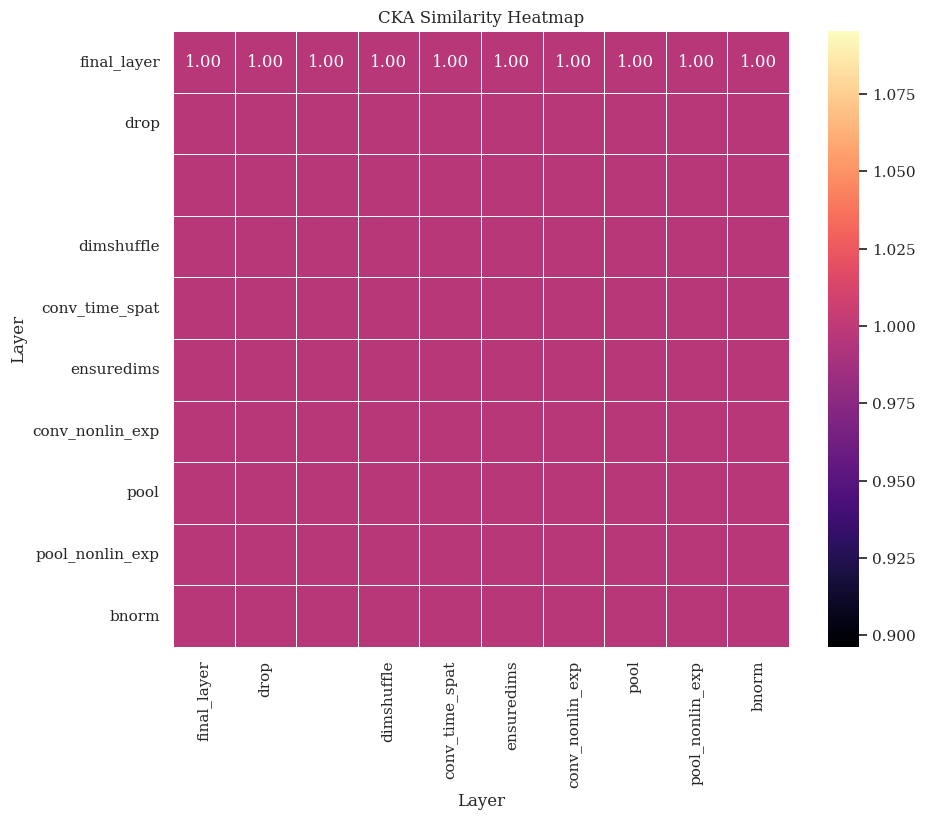

In [98]:
layer_names_model1 = list(activations_model1_copy.keys())
layer_names_model2 = list(activations_model2_copy.keys())

cka_similarities = {}

# Compute CKA for each layer from model1 and model2
for layer1 in layer_names_model1:
    for layer2 in layer_names_model2:
        activations_x = activations_model1_copy[layer1].reshape(activations_model1_copy[layer1].shape[0], -1)
        activations_y = activations_model2_copy[layer2].reshape(activations_model2_copy[layer2].shape[0], -1)

        #print(activations_x.shape)
        #print(activations_y.shape)
        if(layer1 == "conv_time_spat" and layer2 == "conv_time_spat"):
            print(activations_x ,  ": " , activations_y)
        features_x = activations_x.cpu().detach().numpy()
        features_y = activations_y.cpu().detach().numpy()
        if(layer1 == "conv_time_spat" and layer2 == "conv_time_spat"):
            print(features_x ,  ": " , features_y)
            cka_score = feature_space_linear_cka(features_x, features_y)
        if(layer1 == "conv_time_spat" and layer2 == "conv_time_spat"):
            print(layer1 , " : ", layer2, " : ", cka_score)

       

        # Store the result in the dictionary
        cka_similarities[(layer1, layer2)] = cka_score

# Optionally, display the similarity matrix or do further analysis

layers = set([layer for pair in cka_similarities.keys() for layer in pair])

# Initialize a square matrix for the CKA similarities
n_layers = len(layers)
matrix = np.zeros((n_layers, n_layers))

layer_names = list({layer for pair in cka_similarities.keys() for layer in pair})

# Fill the matrix with the CKA similarity values
for (layer1, layer2), similarity in cka_similarities.items():
    i = layer_names.index(layer1)
    j = layer_names.index(layer2)
    matrix[i, j] = similarity
    matrix[j, i] = similarity 


import pandas as pd
df = pd.DataFrame(matrix, index=layer_names, columns=layer_names)
#print(df)

plt.figure(figsize=(10, 8))

# Create the heatmap with annotation in all cells
sns.heatmap(df, annot=True, cmap='magma', fmt='.2f', square=True, linewidths=0.5, cbar=True)

# Add title and labels
plt.title('CKA Similarity Heatmap')
plt.xlabel('Layer')
plt.ylabel('Layer')

# Display the heatmap
plt.show()

In [ ]:
import numpy as np
 # Ensure you have a CKA implementation

# List all the layer names from both models
layer_names_model1 = list(activations_model1_copy.keys())
layer_names_model2 = list(activations_model2_copy.keys())

# Initialize an empty matrix to store similarities
similarity_matrix = np.zeros((len(layer_names_model1), len(layer_names_model2)))



# Compute CKA similarity for every pair of layers (one from each model)
for i, layer1 in enumerate(layer_names_model1):
    for j, layer2 in enumerate(layer_names_model2):
        print(activations_model1_copy[layer1].shape)
        flattened_tensor1 = activations_model1_copy[layer1].view(activations_model1_copy[layer1].shape[0], -1)
        print(activations_model2_copy[layer2].shape)
        flattened_tensor2 = activations_model2_copy[layer2].view(activations_model2_copy[layer2].shape[0], -1)

        similarity_matrix[i, j] = cka(gram_linear(np.array(flattened_tensor1)), gram_linear(np.array(flattened_tensor2)))

# Convert the matrix to a DataFrame for readability
import pandas as pd
df = pd.DataFrame(similarity_matrix, index=layer_names_model1, columns=layer_names_model2)

# Display the similarity matrix
print(df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.title("CKA Similarity Between Model Layers")
plt.show()
